<!DOCTYPE html>
<head>
    <meta charset="utf-8">
    <link rel="stylesheet" href="styles.css">
    <link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
    <div style="background-color: #3D0069; color: white ; font-family: 'Merriweather'; font-weight: bold; text-align: center; padding: 40px; font-size: 16px;">
    <h1>Interrogation of the Parch  & Posey (P & P) Database to Improve Sales Performance</h1>
        by
    
    Buhari Shehu (The Datavestigator)
     

</head>


<img src="erd.png" width=700 height=200 />

<div style="background-color: #F5E8DA; padding: 10px;font-family: 'Merriweather'; font-size: 16px;">
<h2>Table of Contents</h2>
<ol>
<li><a href="#intro">Executive Summary</a></li>    
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Methodology</a></li>
<li><a href="#eda">Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#model">Recommendations</a></li>
<li><a href="#references">References</a></li>
</ol>
</div>

<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  1. Executive Summary
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  2. Introduction
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  3. Methodology
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  4. Analysis
</h2>


### 4.1 Import dependencies and load the database

In [6]:
# Import data analysis toolkits
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# Override matplotlib 
sns.set()

In [7]:
# Load Magic commands
%load_ext sql

# Load SQLite database
%sql sqlite:///pandp.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>Which tables are in the database?</b>
</div>

In [13]:
%%sql
SELECT name tables
FROM sqlite_master 
WHERE type IN ('table','view') AND name NOT LIKE 'sqlite_%' 
ORDER BY 1;

 * sqlite:///pandp.db
Done.


tables
accounts
orders
region
sales_reps
web_events


<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in **`December 4th, 2013`** and the most recent order was placed on **`January 2nd, 2017`**. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

### Sales representatives

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>How many sales representatives do P&P has?</b>
</div>

In [16]:
%%sql
SELECT COUNT(*) 'number of sales persons'
FROM sales_reps;

 * sqlite:///pandp.db
Done.


number of sales persons
50


P&P has 50 sales representatives.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>Who are the top 5 and lowest 5 performing sales representatives?</b>
</div>

In [24]:
%%sql
SELECT s.name sales_rep, ROUND(SUM(o.total_amt_usd), 2) total_sales
FROM sales_reps s
JOIN accounts a
ON s.id = a.sales_rep_id
JOIN orders o
ON a.id = o.account_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5;

 * sqlite:///pandp.db
Done.


sales_rep,total_sales
Earlie Schleusner,1098137.72
Tia Amato,1010690.6
Vernita Plump,934212.93
Georgianna Chisholm,886244.12
Arica Stoltzfus,810353.34


In [25]:
%%sql
SELECT s.name sales_rep, ROUND(SUM(o.total_amt_usd), 2) total_sales
FROM sales_reps s
JOIN accounts a
ON s.id = a.sales_rep_id
JOIN orders o
ON a.id = o.account_id
GROUP BY 1
ORDER BY 2
LIMIT 5;

 * sqlite:///pandp.db
Done.


sales_rep,total_sales
Nakesha Renn,49361.11
Julie Starr,89097.65
Elba Felder,114976.59
Kathleen Lalonde,116307.79
Akilah Drinkard,136613.99


### What is the performance trends/behaviour of the top performing sales reps??

In [77]:
%%sql
SELECT s.name sales_rep, STRFTIME('%Y', o.occurred_at) year, ROUND(SUM(o.total_amt_usd), 2) total_sales
FROM sales_reps s
JOIN accounts a
ON s.id = a.sales_rep_id
JOIN orders o
ON a.id = o.account_id
WHERE s.name IN ('Earlie Schleusner', 'Tia Amato', 'Vernita Plump', 'Georgianna Chisholm', 'Arica Stoltzfus')
GROUP BY 1, 2
ORDER BY 1;

 * sqlite:///pandp.db
Done.


sales_rep,year,total_sales
Arica Stoltzfus,2013,19596.7
Arica Stoltzfus,2014,178758.0
Arica Stoltzfus,2015,312236.42
Arica Stoltzfus,2016,291377.61
Arica Stoltzfus,2017,8384.61
Earlie Schleusner,2013,33182.64
Earlie Schleusner,2014,253434.98
Earlie Schleusner,2015,241763.05
Earlie Schleusner,2016,560717.22
Earlie Schleusner,2017,9039.83


In [87]:
# Create high sales reps df
high_sales_reps_query = %sql SELECT s.name sales_rep, STRFTIME('%Y', o.occurred_at) year, ROUND(SUM(o.total_amt_usd), 2) total_sales FROM sales_reps s JOIN accounts a ON s.id = a.sales_rep_id JOIN orders o ON a.id = o.account_id WHERE s.name IN ('Earlie Schleusner', 'Tia Amato', 'Vernita Plump', 'Georgianna Chisholm', 'Arica Stoltzfus') GROUP BY 1, 2 ORDER BY 2
high_sales_reps_df = high_sales_reps_query.DataFrame()

 * sqlite:///pandp.db
Done.


In [88]:
high_sales_reps_df

,sales_rep,year,total_sales
0,Arica Stoltzfus,2013,19596.70
1,Earlie Schleusner,2013,33182.64
2,Tia Amato,2013,22204.81
3,Vernita Plump,2013,11752.37
4,Arica Stoltzfus,2014,178758.00
5,Earlie Schleusner,2014,253434.98
6,Georgianna Chisholm,2014,43677.04
7,Tia Amato,2014,241150.65
8,Vernita Plump,2014,158739.14
9,Arica Stoltzfus,2015,312236.42


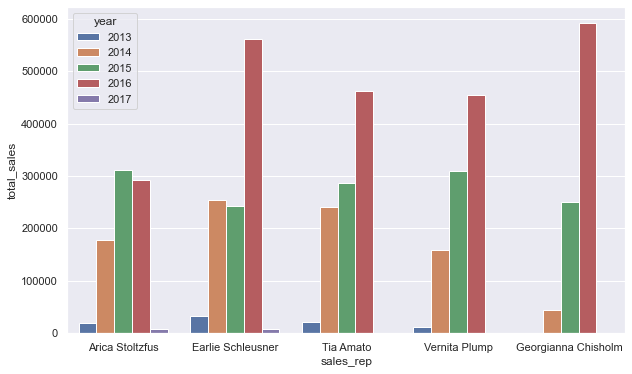

In [89]:
# Create the plot
plt.figure(figsize=(10, 6)) 

# Create the plot
sns.barplot(x='sales_rep', y='total_sales', hue='year', data=high_sales_reps_df)

# Show the plot
plt.show()

### Why Nakesha Renn and co are having low cummulative sales?

In [31]:
%%sql
SELECT s.name sales_rep, STRFTIME('%Y', o.occurred_at) year, ROUND(SUM(o.total_amt_usd), 2) total_sales
FROM sales_reps s
JOIN accounts a
ON s.id = a.sales_rep_id
JOIN orders o
ON a.id = o.account_id
WHERE s.name IN ('Nakesha Renn', 'Julie Starr', 'Elba Felder', 'Kathleen Lalonde', 'Akilah Drinkard')
GROUP BY 1, 2
ORDER BY 1;

 * sqlite:///pandp.db
Done.


sales_rep,year,total_sales
Akilah Drinkard,2014,41117.38
Akilah Drinkard,2015,38109.41
Akilah Drinkard,2016,57387.2
Elba Felder,2013,1228.72
Elba Felder,2014,22893.08
Elba Felder,2015,38088.2
Elba Felder,2016,51730.02
Elba Felder,2017,1036.57
Julie Starr,2013,738.54
Julie Starr,2014,22979.77


In [74]:
# Create low sales reps df
low_sales_reps_query = %sql SELECT s.name sales_rep, STRFTIME('%Y', o.occurred_at) year, ROUND(SUM(o.total_amt_usd), 2) total_sales FROM sales_reps s JOIN accounts a ON s.id = a.sales_rep_id JOIN orders o ON a.id = o.account_id WHERE s.name IN ('Nakesha Renn', 'Julie Starr', 'Elba Felder', 'Kathleen Lalonde', 'Akilah Drinkard') GROUP BY 1, 2 ORDER BY 2 
low_sales_reps_df = low_sales_reps_query.DataFrame()

 * sqlite:///pandp.db
Done.


In [75]:
low_sales_reps_df

,sales_rep,year,total_sales
0,Elba Felder,2013,1228.72
1,Julie Starr,2013,738.54
2,Akilah Drinkard,2014,41117.38
3,Elba Felder,2014,22893.08
4,Julie Starr,2014,22979.77
5,Akilah Drinkard,2015,38109.41
6,Elba Felder,2015,38088.20
7,Akilah Drinkard,2016,57387.20
8,Elba Felder,2016,51730.02
9,Julie Starr,2016,65379.34


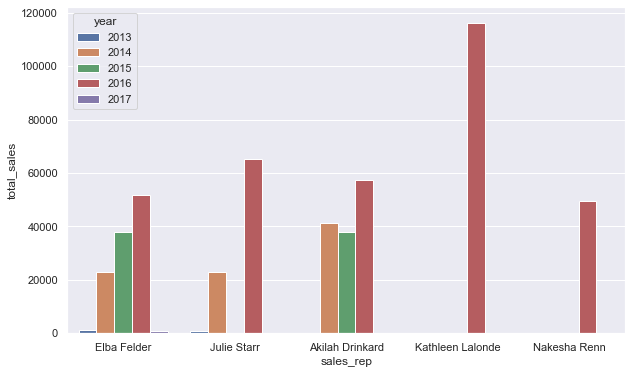

In [76]:
# Create the plot
plt.figure(figsize=(10, 6)) 

# Create the plot
sns.barplot(x='sales_rep', y='total_sales', hue='year', data=low_sales_reps_df)

# Show the plot
plt.show()

### Customers

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

**How many customers?**

In [93]:
%%sql
SELECT COUNT(*) number_of_customers
FROM accounts;

 * sqlite:///pandp.db
Done.


number_of_customers
351


**Top 5 and lowest 5 cutomers**

In [98]:
%%sql
SELECT a.name, ROUND(SUM(o.total_amt_usd), 2) total_purchase
FROM accounts a
JOIN orders o
ON a.id = o.account_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5;

 * sqlite:///pandp.db
Done.


name,total_purchase
EOG Resources,382873.3
Mosaic,345618.59
IBM,326819.48
General Dynamics,300694.79
Republic Services,293861.14


In [101]:
%%sql
WITH cte AS (SELECT a.name, ROUND(SUM(o.total_amt_usd), 2) total_purchase
FROM accounts a
JOIN orders o
ON a.id = o.account_id
GROUP BY 1
ORDER BY 2
LIMIT 5)

SELECT *
FROM cte
ORDER BY 2 DESC;

 * sqlite:///pandp.db
Done.


name,total_purchase
Bed Bath & Beyond,1069.64
Deere,1036.57
Level 3 Communications,881.73
Delta Air Lines,859.64
Nike,390.25


**Habits of top and lowest customers**

**New Customers**

In [109]:
%%sql
SELECT  STRFTIME('%Y', occurred_at) year,  COUNT(DISTINCT account_id) number_of_customers
FROM orders
GROUP BY 1;

 * sqlite:///pandp.db
Done.


year,number_of_customers
2013,61
2014,80
2015,134
2016,317
2017,14


In [126]:
%%sql
WITH cte1 AS (SELECT DISTINCT account_id FROM orders WHERE STRFTIME('%Y', occurred_at) != '2013')

WITH cte2 AS (SELECT DISTINCT account_id FROM orders WHERE STRFTIME('%Y', o.occurred_at) = '2013')

SELECT *
FROM cte1
INTERSECT
SELECT *
FROM cte2

 * sqlite:///pandp.db
(sqlite3.OperationalError) near "WITH": syntax error
[SQL: WITH cte1 AS (SELECT DISTINCT account_id FROM orders WHERE STRFTIME('%Y', occurred_at) != '2013')

WITH cte2 AS (SELECT DISTINCT account_id FROM orders WHERE STRFTIME('%Y', o.occurred_at) = '2013')

SELECT *
FROM cte1
INTERSECT
SELECT *
FROM cte2]
(Background on this error at: https://sqlalche.me/e/14/e3q8)


In [119]:
%%sql
SELECT COUNT(DISTINCT account_id)
FROM orders 
WHERE STRFTIME('%Y', occurred_at) != '2013'

 * sqlite:///pandp.db
Done.


COUNT(DISTINCT account_id)
349


Sales persons
- How many
- Top 5 and Lowest 5?

Cutomers
- Count
- Top 5 and lowest 5
- Habits of top and low
- New customers
- Without poc
- Attrition
- Customer segmentation based on their purchase: CASE, Know the distribution of the , Plot their distribution after segmenting 




Channels
- Distribution 
- Trend
- Regions
- Top regions

Products
- Top product of all time
- Trends for three years
- MAX orders for all
- MIN orders 
- Average orders
- Distribution of orders 




Growth
- Ytd
- Running totals
- That comparison chart
- Lead, lag?.
- Annual growth rates comparison
- Trends YOY
Compare monthly and annual number of sales




<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="font-size: 18px; font-family: 'Merriweather'">
  When were the earliest and latest orders placed?
</div>

In [9]:
%%sql
SELECT t1.id, t1.name, t1.channel, MAX(count) max_chan
FROM (SELECT a.id, a.name, w.channel, COUNT(*) count
FROM accounts a
JOIN web_events w
ON a.id = w.account_id
GROUP BY 1, 2, 3) t1
GROUP BY 1, 2

 * sqlite:///pandp.db
Done.


id,name,channel,max_chan
1001,Walmart,direct,22
1011,Exxon Mobil,adwords,1
1021,Apple,direct,9
1031,Berkshire Hathaway,direct,1
1041,McKesson,direct,5
1051,UnitedHealth Group,direct,9
1061,CVS Health,direct,4
1071,General Motors,direct,1
1081,Ford Motor,direct,29
1091,AT&T,direct,35


In [ ]:
%%sql
SELECT id,
        account_id,
        standard_qty,
        STRFTIME('%Y %m', occurred_at) month,
        DENSE_RANK() OVER (PARTITION BY account_id ORDER BY STRFTIME('%Y %m', occurred_at)) AS dense_rank,
        SUM(standard_qty) OVER (PARTITION BY account_id ORDER BY STRFTIME('%Y %m', occurred_at)) AS running_sum_std_qty,
        COUNT(standard_qty) OVER (PARTITION BY account_id ORDER BY STRFTIME('%Y %m', occurred_at)) AS count__std_qty,
        AVG(standard_qty) OVER (PARTITION BY account_id ORDER BY STRFTIME('%Y %m', occurred_at)) AS avg__std_qty,
        MIN(standard_qty) OVER (PARTITION BY account_id ORDER BY STRFTIME('%Y %m', occurred_at)) AS min__std_qty,
        MAX(standard_qty) OVER (PARTITION BY account_id ORDER BY STRFTIME('%Y %m', occurred_at)) AS max__std_qty
FROM orders

In [ ]:
%%sql
WITH cte AS (SELECT account_id,
        SUM(standard_qty) AS sum_std_qty
        FROM orders
        GROUP BY 1)
SELECT  account_id,
        sum_std_qty,
        LAG(sum_std_qty) OVER (ORDER BY sum_std_qty) AS lag,
        LEAD(sum_std_qty) OVER (ORDER BY sum_std_qty) AS lead,
        sum_std_qty - LAG(sum_std_qty) OVER (ORDER BY sum_std_qty) AS lag_diffrence,
        LEAD(sum_std_qty) OVER (ORDER BY sum_std_qty) - sum_std_qty AS lead_diffrence
FROM cte


In [ ]:
%%sql
SELECT id, account_id, standard_qty, SUM(standard_qty) OVER (ORDER BY id) AS total
FROM orders;

In [ ]:
%%sql
SELECT id,
        account_id,
        occurred_at,
        standard_qty,
        NTILE(4) OVER (ORDER BY standard_qty) AS quartile,
        NTILE(5) OVER (ORDER BY standard_qty) AS quintile,
        NTILE(100) OVER (ORDER BY standard_qty) AS percentile
FROM orders
ORDER BY standard_qty DESC

In [ ]:
%%sql
SELECT t3.id, t3.name, t3.channel, t3.count
FROM (SELECT a.id, a.name, w.channel, COUNT(*) count
FROM accounts a
JOIN web_events w
ON a.id = w.account_id
GROUP BY 1, 2, 3) t3


JOIN (SELECT t1.id, t1.name, MAX(count) max_chan
FROM (SELECT a.id, a.name, w.channel, COUNT(*) count
FROM accounts a
JOIN web_events w
ON a.id = w.account_id
GROUP BY 1, 2, 3) t1
GROUP BY 1, 2
ORDER BY 1) t2
ON t2.id = t3.id AND t2.max_chan = t3.count
ORDER BY 1, 4


In [ ]:
%%sql
SELECT standard_qty,
       SUM(total) OVER(ORDER BY occurred_at) AS running_total
FROM orders

In [156]:
%%sql
SELECT strftime('%Y %m', occurred_at) months, ROUND(AVG(total_amt_usd), 2) average_sales
FROM orders
WHERE occurred_at LIKE '2015%'
GROUP BY 1

 * sqlite:///pandp.db
Done.


months,average_sales
2015 01,2922.73
2015 02,3239.69
2015 03,4026.38
2015 04,3672.79
2015 05,2916.65
2015 06,3314.22
2015 07,3163.67
2015 08,3198.31
2015 09,3648.92
2015 10,3166.8


In [72]:
%%sql
SELECT w.channel, ROUND(SUM(o.total_amt_usd), 2) total_sales
FROM orders o
JOIN accounts a
ON o.account_id = a.id
JOIN web_events w
ON w.account_id = a.id
WHERE o.occurred_at BETWEEN '2015-01-01' AND '2016-01-01'
GROUP BY 1
ORDER BY 2 DESC;

 * sqlite:///pandp.db
Done.


channel,total_sales
direct,201196130.62
facebook,31954065.03
organic,31918987.73
adwords,30321237.21
twitter,16374278.84
banner,14248005.61


## 2. Connecting to a serverless SQL database

We can connect to a SQLite database as follows: 

1. We need to install some dependencies. This includes the following Python modules: 

 - Running ***locally***: Once-off installations
      - `pip install sqlalchemy`
      - `pip install ipython-sql`
      - `pip install pymysql`

 - Running on ***Google Colab***: 
      - no dependencies required

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #D9EEE1">
  <b>Which tables are in the database?</b>
</div>

In [16]:
%%sql
SELECT * 
FROM orders
LIMIT 5;

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
1,1001,2015-10-06 17:31:14,123,22,24,169,613.77,164.78,194.88,973.43
2,1001,2015-11-05 03:34:33,190,41,57,288,948.1,307.09,462.84,1718.03
3,1001,2015-12-04 04:21:55,85,47,0,132,424.15,352.03,0,776.18
4,1001,2016-01-02 01:18:24,144,32,0,176,718.56,239.68,0,958.24
5,1001,2016-02-01 19:27:27,108,29,28,165,538.92,217.21,227.36,983.49


<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>What are the five latest orders?</b>
</div>

In [15]:
%%sql
SELECT *
FROM orders
ORDER BY occurred_at DESC
LIMIT 5;

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
6451,3841,2017-01-02 00:02:40,42,506,302,850,209.58,3789.94,2452.24,6451.76
3546,3841,2017-01-01 23:50:16,291,36,26,353,1452.09,269.64,211.12,1932.85
6454,3861,2017-01-01 22:29:50,38,167,51,256,189.62,1250.83,414.12,1854.57
3554,3861,2017-01-01 22:17:26,497,0,23,520,2480.03,0,186.76,2666.79
6556,4051,2017-01-01 21:04:25,0,65,50,115,0,486.85,406,892.85


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>In which accounts did the top five purchases of all time occur?<b>
</div>

In [18]:
%%sql
SELECT account_id, total_amt_usd
FROM orders
ORDER BY total_amt_usd DESC
LIMIT 5;

 * sqlite:///pandp.db
Done.


account_id,total_amt_usd
4251,232207.07
4161,112875.18
4211,107533.55
2861,95005.82
4101,93547.84


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>In which accounts did the lowest five purchases of all time occur?<b>
</div>

In [19]:
%%sql
SELECT account_id, total_amt_usd
FROM orders
ORDER BY total_amt_usd
LIMIT 5;

 * sqlite:///pandp.db
Done.


account_id,total_amt_usd
1131,0
1951,0
2881,0
1221,0
1231,0


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>Which records have total purchase greater than $100,000 ?<b>
</div>

In [25]:
%%sql
SELECT *
FROM orders
WHERE total_amt_usd > 100000;

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
3892,4161,2016-06-24 13:32:55,22591,13,6,22610,112729.09,97.37,48.72,112875.18
3963,4211,2015-03-30 00:05:30,114,14281,0,14395,568.86,106964.69,0,107533.55
4016,4251,2016-12-26 08:53:24,521,16,28262,28799,2599.79,119.84,229487.44,232207.07


In [ ]:
#Which channel which sales rep in what region names of companies that these sales were made?
%%sql
SELECT w.channel
FROM orders
JOIN web_events w
WHERE total_amt_usd > 100000;

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the account names and the sales representative for the top three accounts above?</b>
</div>

In [57]:
%%sql
SELECT a.name account_name, s.name sales_rep,  o.total_amt_usd
FROM orders o
JOIN accounts a
ON o.account_id = a.id
JOIN sales_reps s
ON a.sales_rep_id = s.id
WHERE total_amt_usd > 100000
ORDER BY 3 DESC;

 * sqlite:///pandp.db
Done.


account_name,sales_rep,total_amt_usd
Pacific Life,Dawna Agnew,232207.07
Core-Mark Holding,Maryanna Fiorentino,112875.18
EOG Resources,Arica Stoltzfus,107533.55


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the names, websites and primary points of contact of the top three accounts above?<b>
</div>

In [31]:
%%sql
SELECT name, website, primary_poc
FROM accounts
WHERE id in (4161, 4211, 4251);

 * sqlite:///pandp.db
Done.


name,website,primary_poc
Core-Mark Holding,www.core-mark.com,Marita Demasi
EOG Resources,www.eogresources.com,Alida Desrosier
Pacific Life,www.pacificlife.com,Kyoko Randall


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What is the unit price of a standard paper?</b>
</div>

In [36]:
%%sql
SELECT standard_amt_usd/standard_qty standard_paper_unit_price_usd
FROM orders
LIMIT 1;

 * sqlite:///pandp.db
Done.


standard_paper_unit_price_usd
4.99


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>Which orders contain only standard paper with a quantity greater than 1000?<b>
</div>

In [37]:
%%sql
SELECT *
FROM orders
WHERE standard_qty > 1000 AND poster_qty = 0 AND gloss_qty = 0;

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
2613,2951,2016-08-15 00:06:12,1171,0,0,1171,5843.29,0,0,5843.29
3260,3491,2014-08-29 22:43:00,1552,0,0,1552,7744.48,0,0,7744.48


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>Which orders were placed between 2014-12-29 and 2014-12-30?</b>
</div>

In [44]:
%%sql
SELECT *
FROM orders
WHERE occurred_at BETWEEN '2014-12-29' AND '2014-12-31';

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
256,1251,2014-12-30 02:30:01,336,52,12,400,1676.64,389.48,97.44,2163.56
604,1451,2014-12-29 07:50:25,412,0,0,412,2055.88,0,0,2055.88
3084,3411,2014-12-29 06:34:35,286,12,22,320,1427.14,89.88,178.64,1695.66
3960,4211,2014-12-29 22:37:31,96,19,16,131,479.04,142.31,129.92,751.27
4163,4341,2014-12-29 04:40:43,584,36,12,632,2914.16,269.64,97.44,3281.24
4465,1251,2014-12-30 02:10:42,510,574,202,1286,2544.9,4299.26,1640.24,8484.4
4697,1451,2014-12-29 07:40:17,54,542,271,867,269.46,4059.58,2200.52,6529.56
6168,3411,2014-12-29 06:27:25,43,615,301,959,214.57,4606.35,2444.12,7265.04
6688,4211,2014-12-29 22:41:19,513,568,190,1271,2559.87,4254.32,1542.8,8356.99


In [46]:
%%sql
SELECT orders.*,
accounts.*
FROM orders
JOIN accounts
ON orders.account_id = accounts.id
LIMIT 5;

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd,id_1,name,website,lat,long,primary_poc,sales_rep_id
1,1001,2015-10-06 17:31:14,123,22,24,169,613.77,164.78,194.88,973.43,1001,Walmart,www.walmart.com,40.23849561,-75.10329704,Tamara Tuma,321500
2,1001,2015-11-05 03:34:33,190,41,57,288,948.1,307.09,462.84,1718.03,1001,Walmart,www.walmart.com,40.23849561,-75.10329704,Tamara Tuma,321500
3,1001,2015-12-04 04:21:55,85,47,0,132,424.15,352.03,0,776.18,1001,Walmart,www.walmart.com,40.23849561,-75.10329704,Tamara Tuma,321500
4,1001,2016-01-02 01:18:24,144,32,0,176,718.56,239.68,0,958.24,1001,Walmart,www.walmart.com,40.23849561,-75.10329704,Tamara Tuma,321500
5,1001,2016-02-01 19:27:27,108,29,28,165,538.92,217.21,227.36,983.49,1001,Walmart,www.walmart.com,40.23849561,-75.10329704,Tamara Tuma,321500


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>How much sales were generated by each channel in 2015?</b>
</div>

In [94]:
%%sql
SELECT w.channel, ROUND(SUM(o.total_amt_usd/1e6), 2) total_sales_million_usd
FROM orders o
JOIN accounts a
ON o.account_id = a.id
JOIN web_events w
ON w.account_id = a.id
WHERE o.occurred_at BETWEEN '2015-01-01' AND '2016-01-01'
GROUP BY 1
ORDER BY 2 DESC;

 * sqlite:///pandp.db
Done.


channel,total_sales_million_usd
direct,201.2
facebook,31.95
organic,31.92
adwords,30.32
twitter,16.37
banner,14.25


In [133]:
# create revenue by channel
channel = %sql SELECT w.channel, ROUND(SUM(o.total_amt_usd/1e6), 2) total_sales_million_usd FROM orders o JOIN accounts a ON o.account_id = a.id JOIN web_events w ON w.account_id = a.id WHERE o.occurred_at BETWEEN '2015-01-01' AND '2016-01-01' GROUP BY 1 ORDER BY 2 DESC;
channel_df = channel.DataFrame()

 * sqlite:///pandp.db
Done.


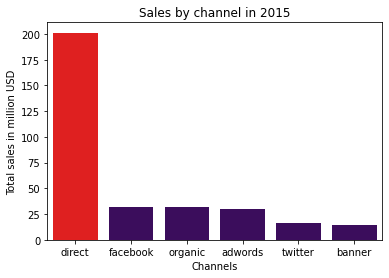

In [138]:
# Create a bar plot with the 'channel' column on the x-axis and the 'total_sales_million_usd' column on the y-axis
# Define colour palette
colour = '#3D0069'
colours = [colour for i in range(len(channel_df)-1)]
palette = ['red']
palette.extend(colours)

ax = sns.barplot(x='channel', y='total_sales_million_usd', data=channel_df, palette=palette)

# Set the x-axis label to 'Channels'
ax.set_xlabel('Channels')

# Set the y-axis label to 'Total sales in million USD'
ax.set_ylabel('Total sales in million USD')

# Set the title to 'Revenue by channel in 2015'
ax.set_title('Sales by channel in 2015');


In [136]:
%%sql
SELECT MAX(occurred_at) 
FROM orders

 * sqlite:///pandp.db
Done.


MAX(occurred_at)
2017-01-02 00:02:40


In [137]:
%%sql
SELECT MIN(occurred_at) 
FROM orders

 * sqlite:///pandp.db
Done.


MIN(occurred_at)
2013-12-04 04:22:44


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>Comparing 2016 to 2015, how did sales fare?</b>
</div>

In [187]:
%%sql
SELECT strftime('%Y %m', occurred_at) years, strftime('%m', occurred_at) months, ROUND(AVG(total_amt_usd), 2) average_sales
FROM orders
WHERE occurred_at LIKE '2015%' OR occurred_at LIKE '2016%'
GROUP BY 1

 * sqlite:///pandp.db
Done.


years,months,average_sales
2015 01,01,2922.73
2015 02,02,3239.69
2015 03,03,4026.38
2015 04,04,3672.79
2015 05,05,2916.65
2015 06,06,3314.22
2015 07,07,3163.67
2015 08,08,3198.31
2015 09,09,3648.92
2015 10,10,3166.8


In [184]:
average_sales = %sql SELECT strftime('%Y %m', occurred_at) years, strftime('%m', occurred_at) months, ROUND(AVG(total_amt_usd), 2) average_sales FROM orders WHERE occurred_at LIKE '2015%' OR occurred_at LIKE '2016%' GROUP BY 1
average_sales_df = average_sales.DataFrame()

 * sqlite:///pandp.db
Done.


In [190]:
3301.95 - 4026.38

-724.4300000000003

In [185]:
average_sales_df

,years,months,average_sales
0,2015 01,01,2922.73
1,2015 02,02,3239.69
2,2015 03,03,4026.38
3,2015 04,04,3672.79
4,2015 05,05,2916.65
5,2015 06,06,3314.22
6,2015 07,07,3163.67
7,2015 08,08,3198.31
8,2015 09,09,3648.92
9,2015 10,10,3166.80


<AxesSubplot:xlabel='months', ylabel='yoy_change'>

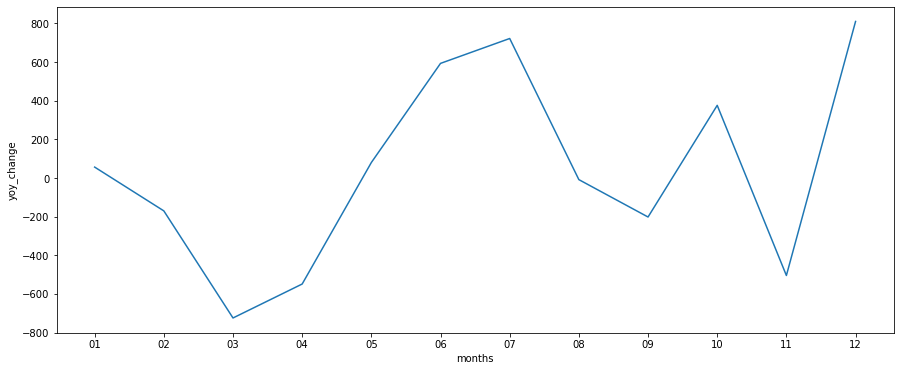

In [186]:
average_sales_df['yoy_change'] = average_sales_df['average_sales'] - average_sales_df['average_sales'].shift(12)
# Set the figure size to 10 inches wide and 6 inches tall

plt.figure(figsize=(15, 6))
# Create a line plot with the year on the x-axis and the YoY change on the y-axis
sns.lineplot(x='months', y='yoy_change', data=average_sales_df)

- high variability
- overall 2015 was better
- seems no seasonality in the dataset
- high volatility = high variability?

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the 10 latest orders?<b>
</div>

Which channel send the most traffic per day on average to parch and posey
Solution: we need to aggregate events by channel by day then we average them

In [212]:
%%sql
SELECT channel,
       AVG(event_count) AS avg_event_count
FROM 
(SELECT strftime('%Y %m %d', occurred_at) day, 
        channel, 
        COUNT(*) event_count
FROM web_events
GROUP BY 1, 2) sub
GROUP BY 1
ORDER BY 2 DESC

 * sqlite:///pandp.db
Done.


channel,avg_event_count
direct,4.896487985212569
organic,1.6672504378283712
facebook,1.5983471074380164
adwords,1.5701906412478337
twitter,1.3166666666666667
banner,1.2899728997289972


 return only orders that occurred in the same month as PandP first order ever

In [233]:
%%sql
SELECT *
FROM orders
WHERE STRFTIME('%Y %m', occurred_at) LIKE (SELECT STRFTIME('%Y %m', MIN(occurred_at)) earliest_month FROM orders)

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
147,1181,2013-12-17 23:02:57,339,0,0,339,1691.61,0,0,1691.61
243,1251,2013-12-11 20:36:06,86,39,34,159,429.14,292.11,276.08,997.33
287,1281,2013-12-05 20:33:56,492,73,0,565,2455.08,546.77,0,3001.85
346,1301,2013-12-08 07:05:07,85,89,32,206,424.15,666.61,259.84,1350.6
446,1401,2013-12-12 16:33:14,299,39,28,366,1492.01,292.11,227.36,2011.48
484,1411,2013-12-30 21:42:43,498,41,0,539,2485.02,307.09,0,2792.11
561,1441,2013-12-28 12:54:50,317,30,5,352,1581.83,224.7,40.6,1847.13
702,1521,2013-12-31 00:36:59,266,0,26,292,1327.34,0,211.12,1538.46
739,1531,2013-12-10 14:43:18,501,0,0,501,2499.99,0,0,2499.99
795,1561,2013-12-17 21:54:36,380,109,0,489,1896.2,816.41,0,2712.61


In [ ]:
%%sql
SELECT *
FROM 
ORDER BY 
LIMIT 5

In [ ]:
%%sql
SELECT *
FROM 
ORDER BY 
LIMIT 5

In [ ]:
%%sql
SELECT *
FROM 
ORDER BY 
LIMIT 5

In [ ]:
Which channels 
SELECT *
FROM web_events
WHERE channel IN ('organic', 'adwords') AND occurred_at BETWEEN '2016-01-01' AND '2017-01-01'
ORDER BY occurred_at DESC;

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the 10 latest orders?<b>
</div>

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the 10 latest orders?<b>
</div>

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the 10 latest orders?<b>
</div>

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the 10 latest orders?<b>
</div>


<div style="border: 10px solid #6f00ff;
    border-radius: 20px; text-align: center; padding: 20px 0; background-color: #F5E8DA">
  This is a curved edge border box with the color #6f00ff.
</div>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  5. Conclusions
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  6. Recommendations
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  7. References
</h2>



<footer style="background-color: #3D0069; color: white ; font-family: 'Merriweather'; font-weight: bold; text-align: center; padding: 20px 0; font-size: 16px;">
    <p style="text-align: center;"> <i>Datavestigating to connect the facts</i> </p>
    <p style="font-size: 14px; text-align: center;">&copy; The Datavestigator</p>   
</footer>